In [0]:
import pandas as pd
import numpy as np
import pickle
import gzip


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, Conv3DTranspose, UpSampling3D, Reshape
from keras.layers import Input



Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Generator with List, for CAE training

In [0]:
def gen_tr_1():
  while True: # each time will be one round going through all images
    im_num = 0
    batch_num = 0
      
    while True: #for one round through all images
      
      pixels=np.zeros(( 1 , 120, 160, 120))
      while (len(pixels)<3): 
              try:
                  path = '/content/drive/My Drive/PROCESSED/OAS3'
                  path += str(im_num).zfill(4)+'_data'
                  with open(path, 'rb') as f:
                        im= pickle.load(f)
                        pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                        im_num = im_num%1173
                        im_num += 1
              except:
                    im_num = im_num%1173
                    im_num += 1
    
                    pass
      batch_num += 1
      yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
              np.reshape(pixels[1:pixels.shape[0],:,:,:], (pixels.shape[0]-1,120,160,120,1)))

In [0]:
def gen_test_1():
  while True:
    im_num = 0
    batch_num = 0
    while True:
      pixels=np.zeros(( 1 , 120, 160, 120))
      while (len(pixels)<3): 
              try:
                  path = '/content/drive/My Drive/PROCESSED/OAS3'
                  im_num_inv = 1173 - im_num
                  path += str(im_num_inv).zfill(4)+'_data'
                  with open(path, 'rb') as f:
                        im= pickle.load(f)
                        pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                        im_num = im_num%1173
                        im_num += 1
              except:
                    im_num = im_num%1173
                    im_num += 1
                    pass
      batch_num += 1
      yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
              np.reshape(pixels[1:pixels.shape[0],:,:,:], (pixels.shape[0]-1,120,160,120,1)))

In [0]:
train_gen_1 = gen_tr_1()
test_gen_1 = gen_test_1()


### Generator for classifier

In [0]:
def convert_array(x):
    if x == "AD":
        return [1., 0.]
    elif x == "CN":
        return [0., 1.]
    else:
        return x

In [0]:
def gen_tr_c():
 while True:
  im_num = 0
  batch_num = 0
  while True:
    b_labels =[]
    pixels=np.zeros(( 1 , 120, 160, 120))
    while (len(pixels)<2): 
            try:
                path = '/content/drive/My Drive/PROCESSED/OAS3'
                path += str(im_num).zfill(4)+'_data'
                with open(path, 'rb') as f:
                      im= pickle.load(f)
                      pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                      if (im_num>1172): im_num = im_num%1173
                      im_num += 1
                      b_labels.append(im['diagnosis'])
            except:
                  if (im_num>1172): im_num = im_num%1173
                  im_num += 1
                  pass   
    batch_num += 1
    b_l = list(map( convert_array, b_labels))
    b_l = np.reshape(b_l, (len(b_l),2))
    b_l = b_l.astype('float32')
    yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
            b_l)

In [0]:
def gen_test_c():
 while True:
  im_num = 0
  batch_num = 0
  while True:
    b_labels =[]
    pixels=np.zeros(( 1 , 120, 160, 120))
    while (len(pixels)<2): 
            try:
                path = '/content/drive/My Drive/PROCESSED/OAS3'
                im_num_inv = 1173 - im_num
                path += str(im_num_inv).zfill(4)+'_data'
                with open(path, 'rb') as f:
                      im= pickle.load(f)
                      pixels=np.append(pixels,np.reshape(im['image'], (1, 120, 160, 120) ), axis=0) 
                      if (im_num>1172): im_num = im_num%1173
                      im_num += 1
                      b_labels.append(im['diagnosis'])
            except:
                  if (im_num>1172): im_num = im_num%1173
                  im_num += 1
                  pass
    batch_num += 1
    b_l = list(map( convert_array, b_labels))
    b_l = np.reshape(b_l, (len(b_l),2))
    b_l = b_l.astype('float32')
    yield  (np.reshape(pixels[1:pixels.shape[0],:,:,:],(pixels.shape[0]-1,120,160,120,1)),\
            b_l)

In [0]:
class_tr_gen = gen_tr_c()
class_test_gen = gen_test_c()

#### Building Encoder

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPool3D, Dropout, Flatten, Conv3DTranspose, UpSampling3D, Reshape
from keras.layers import Input


input_img = Input(shape= (120, 160, 120 , 1))
x = Conv3D(10, (3,3,3), activation='relu', padding='same')(input_img)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
encoded= Dropout(0.8)(x)

encoded_shape = K.int_shape(x)

#x = Flatten()(x)

#x = Dense(32, activation='selu')(x)
#x= Dense(16, activation='selu')(x)
#encoded = Dense(2, activation='selu')(x)


encoder=Model(input_img, encoded, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 30, 10)    0   

In [10]:
encoded_shape

(None, 15, 20, 15, 10)

#### Building decoder

In [11]:
encoded_input= Input(shape=(encoded_shape[1], encoded_shape[2], encoded_shape[3], encoded_shape[4]))
#x = Dense(16, activation='selu')(encoded_input)
#x= Dense(32, activation='selu')(x)
#x= Dense(np.prod(encoded_shape[1:]))(x)
#x= Reshape((encoded_shape[1], encoded_shape[2], encoded_shape[3], encoded_shape[4]))(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(encoded_input)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(10, (3,3,3), activation='relu', padding='same')(x)
x = UpSampling3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3DTranspose(1, (3,3,3), activation='sigmoid', padding='same')(x)

decoder = Model(encoded_input, x, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 20, 15, 10)    0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 15, 20, 15, 10)    2710      
_________________________________________________________________
up_sampling3d_1 (UpSampling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 40, 30, 10)    0         
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 30, 40, 30, 10)    2710      
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 80, 60, 10)    0   

#### Building Autoencoder

In [12]:
autoencoder= Model(input_img, decoder(encoder(input_img)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
encoder (Model)              (None, 15, 20, 15, 10)    5700      
_________________________________________________________________
decoder (Model)              (None, 120, 160, 120, 1)  8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
cae_hist= autoencoder.fit_generator(generator=train_gen_1, steps_per_epoch = 420, epochs=3, verbose=1 , validation_data=test_gen_1, validation_steps=70, use_multiprocessing=True)


Epoch 1/3
420/420 [==============================] - 1212s 3s/step - loss: 0.0242 - val_loss: 0.0307
Epoch 2/3
420/420 [==============================] - 632s 2s/step - loss: 0.0130 - val_loss: 0.0127
Epoch 3/3
420/420 [==============================] - 581s 1s/step - loss: 0.0115 - val_loss: 0.0166


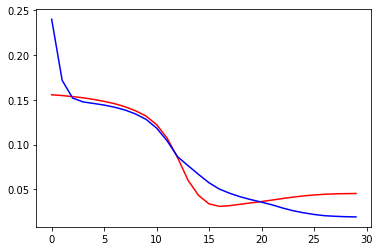

In [0]:
plt.plot(cae_hist.history['val_loss'], 'r', cae_hist.history['loss'], 'b')

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [0]:
#just to save the model. Don't run again
autoencoder.save('cae_1.h5')
model_file = drive.CreateFile({'title' : 'cae_1.h5'})                       
model_file.SetContentFile('cae_1.h5')                       
model_file.Upload()

In [17]:

# Don't run again. download to google drive                       
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1oEctU2Uvk0OJXArdDScsx4ougN4p-uQL'})

In [0]:
#Loading models from Google Drive into Colab, Don't run

file_obj = drive.CreateFile({'id': '1oEctU2Uvk0OJXArdDScsx4ougN4p-uQL'})                       
file_obj.GetContentFile('cae_1.h5')


In [0]:
from keras.models import load_model
cae=load_model('/content/drive/My Drive/cae_1.h5')

In [0]:
# 2 ta 70 ta = test, 12 ta 70 ta train,# 140 ta test, 840 ta train, # 70 ta batch test, 420 ta batch train

###Building Classifier

In [35]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
encoder (Model)              (None, 15, 20, 15, 10)    5700      
_________________________________________________________________
decoder (Model)              (None, 120, 160, 120, 1)  8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.layers import Softmax

In [0]:
encoder_c = autoencoder.layers[1]

In [37]:
encoder_c.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 40, 30, 10)    0   

###New Encoder, classifier to be

In [38]:
input_img = Input(shape= (120, 160, 120 , 1))
x = Conv3D(10, (3,3,3), activation='relu', padding='same')(input_img)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

x = Conv3D(10, (3,3,3), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2))(x)
x= Dropout(0.8)(x)

encoded_shape = K.int_shape(x)

x = Flatten()(x)

x = Dense(32, activation='selu')(x)
x= Dense(16, activation='selu')(x)
new_encoded = Dense(2, activation='softmax')(x)


classifier=Model(input_img, new_encoded, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 40, 30, 10)    0

### Fitting data

In [39]:

classifier.layers

In [0]:
for layer_num in range(len(encoder_c.get_weights())):
  classifier.layers[layer_num].set_weights(encoder_c.layers[layer_num].get_weights())

In [0]:
opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.9)

In [0]:
#didn't freeze
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision(), keras.metrics.Recall(),keras.metrics.AUC()])

In [60]:
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120, 160, 120, 1)  0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 120, 160, 120, 10) 280       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 60, 80, 60, 10)    0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 80, 60, 10)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 60, 80, 60, 10)    2710      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 30, 40, 30, 10)    0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 40, 30, 10)    0

In [61]:
all_class_hist= classifier.fit_generator(generator=class_tr_gen, steps_per_epoch = 420, epochs=3, verbose=1 , validation_data=class_test_gen, validation_steps=70)

Epoch 1/3
420/420 [==============================] - 216s 514ms/step - loss: 0.6547 - accuracy: 0.6500 - precision_2: 0.6314 - recall_2: 0.6314 - auc_1: 0.6226 - val_loss: 0.5165 - val_accuracy: 0.6714 - val_precision_2: 0.6514 - val_recall_2: 0.6514 - val_auc_1: 0.6495
Epoch 2/3
420/420 [==============================] - 275s 654ms/step - loss: 0.6472 - accuracy: 0.6357 - precision_2: 0.6526 - recall_2: 0.6526 - auc_1: 0.6549 - val_loss: 0.5680 - val_accuracy: 0.7143 - val_precision_2: 0.6475 - val_recall_2: 0.6475 - val_auc_1: 0.6606
Epoch 3/3
420/420 [==============================] - 203s 484ms/step - loss: 0.6670 - accuracy: 0.6286 - precision_2: 0.6415 - recall_2: 0.6415 - auc_1: 0.6557 - val_loss: 0.9121 - val_accuracy: 0.6000 - val_precision_2: 0.6426 - val_recall_2: 0.6426 - val_auc_1: 0.6534


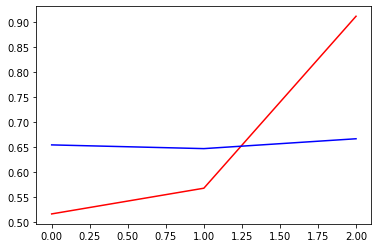

In [62]:
plt.plot(all_class_hist.history['val_loss'], 'r', all_class_hist.history['loss'], 'b')